#### Step 3: Row filters (and counts of what was removed)


In [15]:
# We'll remove rows step by step and track counts

n0 = len(df)

# 1) keep years in scope
mask_year = df["year"].between(2011, CURRENT_YEAR)
df1 = df[mask_year].copy()
removed_year = n0 - len(df1)

# 2) require valid coords inside DC bounding box (simple, good enough for EDA)
in_lat  = df1["LATITUDE"].between(38.7, 39.1)      # DC-ish
in_lon  = df1["LONGITUDE"].between(-77.3, -76.8)
mask_xy = in_lat & in_lon
df2 = df1[mask_xy].copy()
removed_coords = len(df1) - len(df2)

# 3) require a valid timestamp
mask_time = df2["crash_datetime"].notna()
df3 = df2[mask_time].copy()
removed_time = len(df2) - len(df3)

# 4) drop duplicate records (use a few stable keys; adjust if needed)
dupe_keys = [c for c in ["CRIMEID", "CCN", "EVENTID", "crash_datetime", "LATITUDE", "LONGITUDE"] if c in df3.columns]
dup_count = df3.duplicated(subset=dupe_keys, keep="first").sum()
df4 = df3.drop_duplicates(subset=dupe_keys, keep="first").copy()

print({
    "start_rows": n0,
    "removed_year_outside_2011_2025": removed_year,
    "removed_outside_DC_bounds_or_missing_coords": removed_coords,
    "removed_missing_time": removed_time,
    "removed_duplicates": int(dup_count),
    "final_rows": len(df4)
})


{'start_rows': 335578, 'removed_year_outside_2011_2025': 28170, 'removed_outside_DC_bounds_or_missing_coords': 2, 'removed_missing_time': 0, 'removed_duplicates': 0, 'final_rows': 307406}


#### Step 4: Select final columns for analysis (and list what we dropped)

In [17]:
# Location columns we'll use for visuals
location_columns_to_use = ["LATITUDE", "LONGITUDE", "WARD", "ADDRESS"]
location_columns_to_use = [c for c in location_columns_to_use if c in df4.columns]

# Analysis columns (keep this tight and useful)
want_keep = [
    "crash_datetime", "year", "month", "hour", "weekday",
    "severity",
    # location
    *location_columns_to_use,
    # counts (keep if present)
    "TOTAL_VEHICLES", "TOTAL_BICYCLES", "TOTAL_PEDESTRIANS",
    # human factors (keep if present)
    "SPEEDING", "IMPAIREDDRIVER", "IMPAIREDPEDESTRIAN"
]
final_keep = [c for c in want_keep if c in df4.columns]
analysis = df4[final_keep].copy()

# Columns removed (for slides)
removed_columns = sorted(set(df.columns) - set(final_keep))
print("Final analysis columns:", len(final_keep))
print(final_keep)
print("\nRemoved columns count:", len(removed_columns))


Final analysis columns: 13
['crash_datetime', 'year', 'month', 'hour', 'weekday', 'severity', 'LATITUDE', 'LONGITUDE', 'WARD', 'ADDRESS', 'TOTAL_VEHICLES', 'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS']

Removed columns count: 59


#### Step 5 : Missingness for the columns we kept

In [57]:
print({"post_clean_rows": len(analysis), "post_clean_cols": analysis.shape[1]})

miss = analysis.isna().sum().to_frame("n_missing")
miss["pct_missing"] = (miss["n_missing"] / len(analysis)).round(3)
miss.sort_values("n_missing", ascending=False).head(20)

{'post_clean_rows': 307406, 'post_clean_cols': 13}


,n_missing,pct_missing
ADDRESS,82,0.0
crash_datetime,0,0.0
year,0,0.0
month,0,0.0
hour,0,0.0
weekday,0,0.0
severity,0,0.0
LATITUDE,0,0.0
LONGITUDE,0,0.0
WARD,0,0.0


#### Step 6: Save a cleaned file that we could use later (slides/modeling)

analysis.to_csv("dc_crashes_clean.csv", index=False)
print("Saved -> dc_crashes_clean.csv")


### Exploratory Analysis 

#### Step 7: Crashes by year (2011–2025)


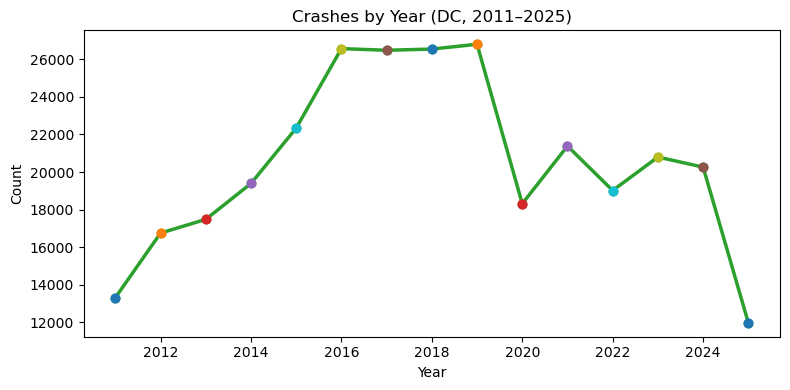

In [23]:
# Crashes by year with varied marker colors 
grp = (analysis.groupby("year").size()
         .loc[lambda s: (s.index >= 2011) & (s.index <= CURRENT_YEAR)])

plt.figure(figsize=(8,4))
plt.plot(grp.index, grp.values, marker="o", linewidth=2.5, color="#2ca02c")  # line color
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd", "#17becf", "#bcbd22", "#8c564b"]
for i, (x, y) in enumerate(zip(grp.index, grp.values)):
    plt.scatter(x, y, s=40, color=colors[i % len(colors)], zorder=3)

plt.title("Crashes by Year (DC, 2011–2025)")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


#### Step 11: Severity distribution (counts)


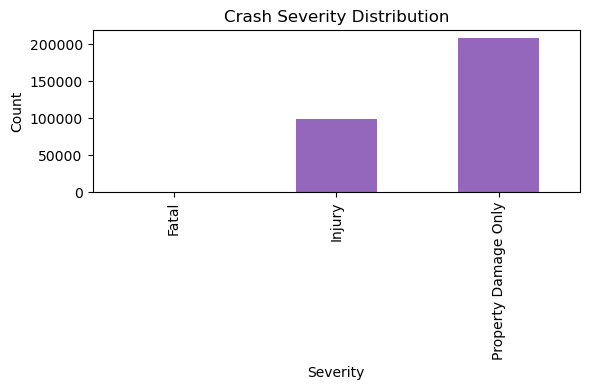

In [25]:
sev = analysis["severity"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sev.plot(kind="bar", color="#9467bd")  # purple
plt.title("Crash Severity Distribution")
plt.xlabel("Severity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


#### Step 8: Crashes by hour of day


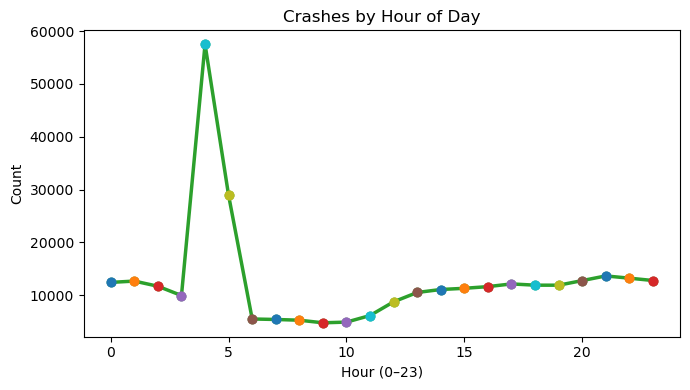

In [27]:
hrs = analysis.groupby("hour").size()

plt.figure(figsize=(7,4))
plt.plot(hrs.index, hrs.values, marker="o", color="#2ca02c", linewidth=2.5)  # green line
# overlay points with multiple colors
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd", "#17becf", "#bcbd22", "#8c564b"]
for i, (x, y) in enumerate(zip(hrs.index, hrs.values)):
    plt.scatter(x, y, s=40, color=colors[i % len(colors)], zorder=3)

plt.title("Crashes by Hour of Day")
plt.xlabel("Hour (0–23)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


#### Step 9 - Crashes by weekday

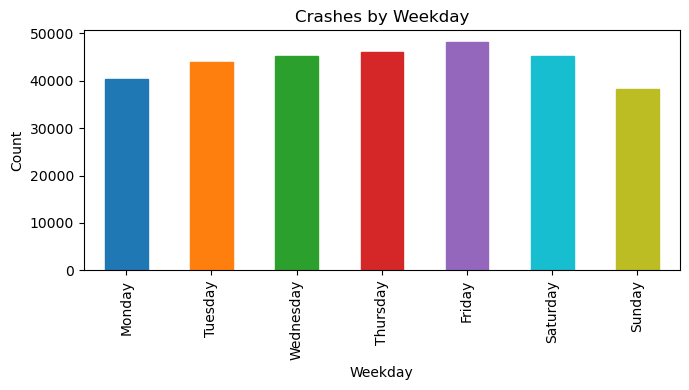

In [29]:
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk = analysis.groupby("weekday").size().reindex(order)

plt.figure(figsize=(7,4))
ax = wk.plot(kind="bar")
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#17becf", "#bcbd22"]
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i % len(colors)])

plt.title("Crashes by Weekday")
plt.xlabel("Weekday"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


#### Step 10: Crashes by ward

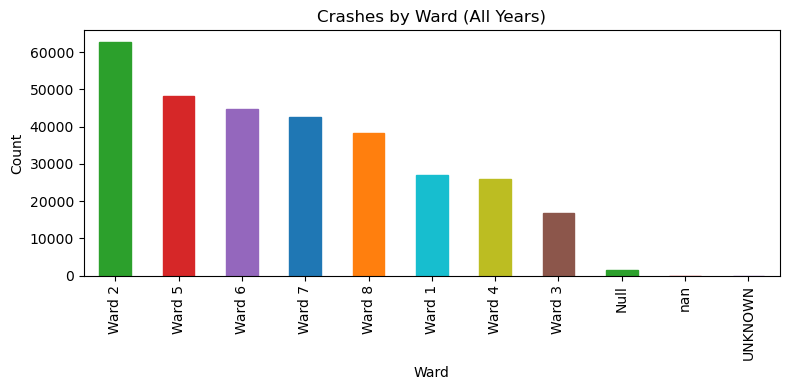

In [31]:
if "WARD" in analysis.columns:
    w = analysis.groupby("WARD").size().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    ax = w.plot(kind="bar")
    colors = ["#2ca02c", "#d62728", "#9467bd", "#1f77b4", "#ff7f0e", "#17becf", "#bcbd22", "#8c564b"]
    for i, bar in enumerate(ax.patches):
        bar.set_color(colors[i % len(colors)])
    plt.title("Crashes by Ward (All Years)")
    plt.xlabel("Ward"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
else:
    print("WARD not available; skip this plot.")



#### Step 11: Spatial density (hexbin)


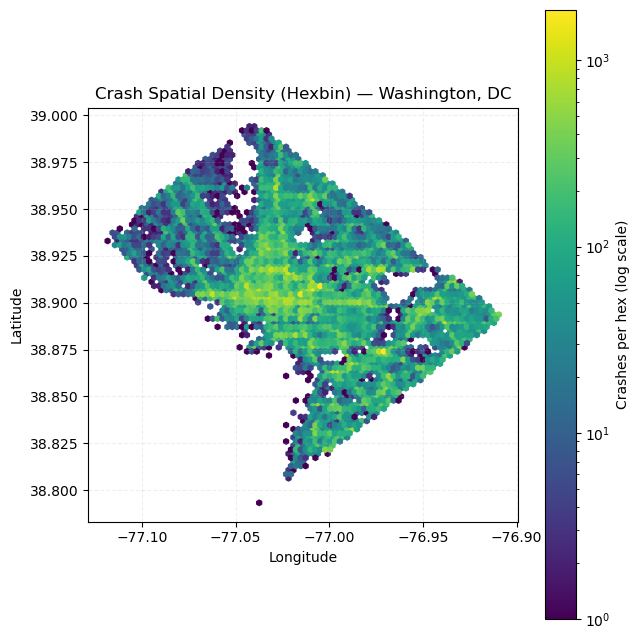

In [33]:
# Crash spatial density (hexbin)
if {"LATITUDE","LONGITUDE"}.issubset(analysis.columns):
    x = analysis["LONGITUDE"]
    y = analysis["LATITUDE"]

    plt.figure(figsize=(6.5,6.5))
    hb = plt.hexbin(x, y, gridsize=80, bins="log", cmap="viridis")  # colored density
    cb = plt.colorbar(hb)
    cb.set_label("Crashes per hex (log scale)")  

    plt.title("Crash Spatial Density (Hexbin) — Washington, DC")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    # optional: equal aspect so the map doesn't look stretched
    plt.gca().set_aspect("equal", adjustable="box")
    # optional: light grid to help read coords
    plt.grid(alpha=0.2, linestyle="--")

    plt.tight_layout(); plt.show()
else:
    print("LAT/LON not available; skip hexbin.")



#### Step 12: Injury-or-Fatal share over time


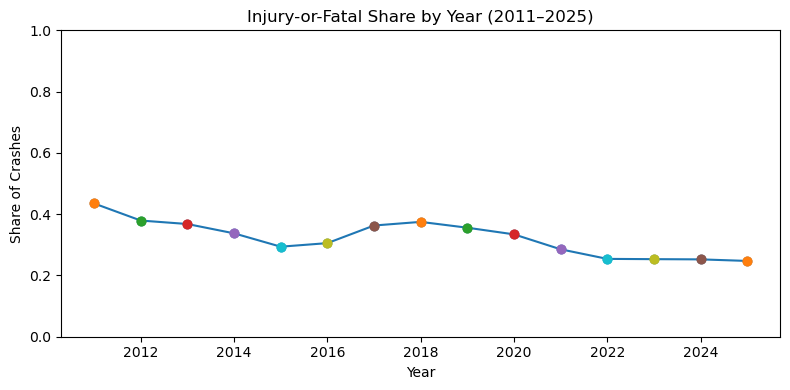

In [35]:
tmp = analysis.copy()
tmp["inj_or_fatal"] = tmp["severity"].isin(["Injury","Fatal"]).astype(int)
share = tmp.groupby("year")["inj_or_fatal"].mean()

plt.figure(figsize=(8,4))
# base line (one color)
share.plot(kind="line", marker="o", color="#1f77b4")
# overlay colored points so markers vary
years = share.index.values
vals  = share.values
colors = ["#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#17becf", "#bcbd22", "#8c564b"]
for i, (x, y) in enumerate(zip(years, vals)):
    plt.scatter(x, y, s=40, color=colors[i % len(colors)], zorder=3)

plt.title("Injury-or-Fatal Share by Year (2011–2025)")
plt.xlabel("Year"); plt.ylabel("Share of Crashes")
plt.ylim(0,1)
plt.tight_layout(); plt.show()


#### Step 13: Top locations (addresses) 


In [37]:
if "ADDRESS" in analysis.columns:
    top_addr = analysis["ADDRESS"].value_counts().head(15)
    display(top_addr.to_frame("count"))
else:
    print("ADDRESS not available; skip top addresses.")


,count
ADDRESS,
INTERSTATE 395 INTERSTATE BN,2328
INTERSTATE 295 INTERSTATE BN,1328
"INTERSTATE 395 INTERSTATE BN\nWASHINGTON,",876
INTERSTATE 695 INTERSTATE BN,811
2300 PENNSYLVANIA AVENUE SE,645
"INTERSTATE 295 INTERSTATE BN\nWASHINGTON,",530
100 NEW YORK AVENUE NE,487
"CONSTITUTION AVENUE NE\nWASHINGTON,",381
50 MASSACHUSETTS AVENUE NE,361


#### Step 14: Heatmap: crashes by weekday and hour (good for scheduling enforcement)



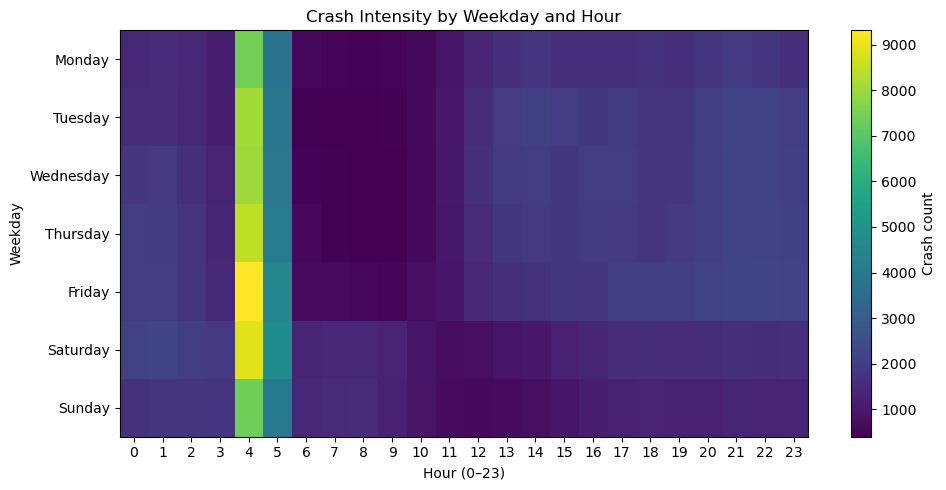

In [39]:
order_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
t = analysis.dropna(subset=["weekday","hour"]).copy()
t = t[t["weekday"].isin(order_days)]

pivot = t.pivot_table(index="weekday", columns="hour", values="severity", aggfunc="size", fill_value=0)
pivot = pivot.reindex(order_days)

plt.figure(figsize=(10,5))
im = plt.imshow(pivot.values, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Crash count")

plt.title("Crash Intensity by Weekday and Hour")
plt.ylabel("Weekday"); plt.xlabel("Hour (0–23)")
plt.yticks(ticks=range(len(pivot.index)), labels=pivot.index)
plt.xticks(ticks=range(0,24,1))
plt.tight_layout(); plt.show()


#### Syep 15: Hexbin map showing SHARE of Injury/Fatal crashes (0 to 1), not just volume


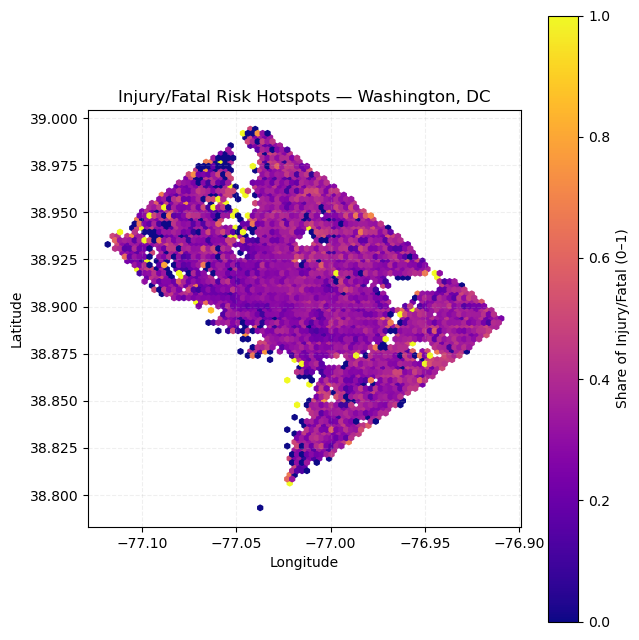

In [41]:
if {"LATITUDE","LONGITUDE"}.issubset(analysis.columns):
    m = analysis.copy()
    m["inj_or_fatal"] = m["severity"].isin(["Injury","Fatal"]).astype(float)

    plt.figure(figsize=(6.5,6.5))
    hb = plt.hexbin(
        m["LONGITUDE"], m["LATITUDE"],
        C=m["inj_or_fatal"],
        reduce_C_function=np.mean,   # average share per hex
        gridsize=80,
        cmap="plasma",
        vmin=0, vmax=1
    )
    cb = plt.colorbar(hb)
    cb.set_label("Share of Injury/Fatal (0–1)")

    plt.title("Injury/Fatal Risk Hotspots — Washington, DC")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid(alpha=0.2, linestyle="--")
    plt.tight_layout(); plt.show()
else:
    print("LAT/LON not available; skip risk map.")


#### Deeper Analysis

In [48]:
# === CONFIG (edit paths if needed) ===
CRASHES_CLEAN_CSV = "dc_crashes_clean.csv" 
WEATHER_RAW_CSV   = "Roadway_Weather_Information_Systems_Sensors.csv"  # new dataset

# Small color palette for consistent charts
PALETTE = {
    "line1": "#1f77b4", "line2": "#ff7f0e",
    "bar1":  "#2ca02c", "bar2": "#d62728", "bar3": "#9467bd",
    "accent": "#17becf", "gold": "#bcbd22", "brown": "#8c564b"
}

def color_bars(ax, colors=None):
    # cycle a list of colors across bar patches
    base = colors or [PALETTE["bar1"], PALETTE["bar2"], PALETTE["bar3"],
                      PALETTE["accent"], PALETTE["gold"], PALETTE["brown"], "#7f7f7f"]
    for i, b in enumerate(ax.patches):
        b.set_color(base[i % len(base)])


#### Severity by Ward (stacked, colored)


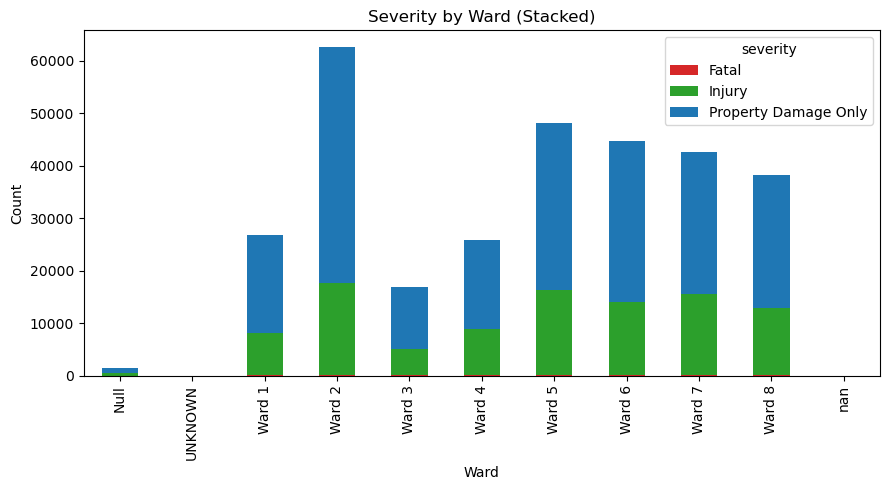

In [60]:
# Stacked bars: which wards skew toward Injury/Fatal vs PDO
if "WARD" in analysis.columns:
    ctab = pd.crosstab(analysis["WARD"], analysis["severity"])
    # enforce consistent order if present
    for col in ["Fatal","Injury","Property Damage Only"]:
        if col not in ctab.columns: ctab[col] = 0
    ctab = ctab[["Fatal","Injury","Property Damage Only"]]

    ax = ctab.plot(kind="bar", stacked=True, figsize=(9,5),
                   color=["#d62728", "#2ca02c", "#1f77b4"])
    plt.title("Severity by Ward (Stacked)")
    plt.xlabel("Ward"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
else:
    print("WARD not available; skip stacked severity chart.")

Most crashes in DC are concentrated in a few wards (especially Ward 2 and Ward 5), and while property damage dominates, the proportion of injuries is consistent across wards. Fatalities are rare but present in all areas.

#### Severity mix: Pedestrian involved vs not


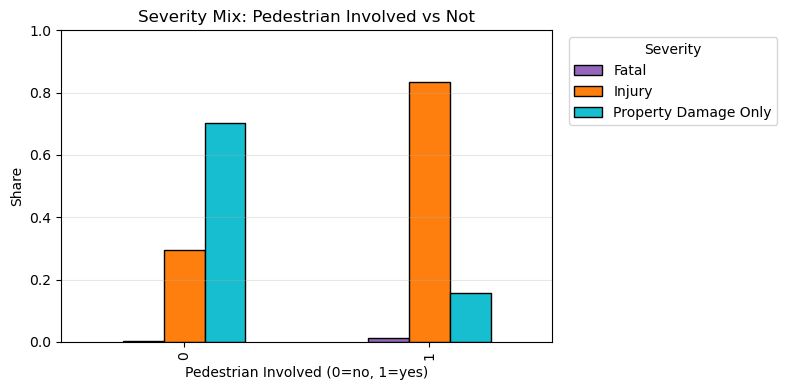

In [294]:
if "TOTAL_PEDESTRIANS" in analysis.columns:
    t = analysis.copy()
    t["ped_involved"] = (t["TOTAL_PEDESTRIANS"] > 0).astype(int)
    mix = (t.groupby("ped_involved")["severity"].value_counts(normalize=True)
             .unstack().reindex(columns=["Fatal","Injury","Property Damage Only"]).fillna(0))
    ax = mix.plot(kind="bar", figsize=(8,4), color=["#9467bd","#ff7f0e","#17becf"], edgecolor="black")
    plt.title("Severity Mix: Pedestrian Involved vs Not")
    plt.xlabel("Pedestrian Involved (0=no, 1=yes)"); plt.ylabel("Share"); plt.ylim(0,1)
    plt.legend(title="Severity", loc="upper left", bbox_to_anchor=(1.02,1))
    plt.grid(axis="y", alpha=.3); plt.tight_layout(); plt.show()
else:
    print("TOTAL_PEDESTRIANS not available; skip.")


When pedestrians are involved, crashes are far more likely to result in injuries and occasionally fatalities, while property-damage-only cases drop sharply. In contrast, crashes without pedestrians are mostly minor, with the majority involving only property damage. This highlights pedestrian involvement as a key driver of crash severity.

## 3. Weather Data Cleaning & Integration


To extend beyond crash-only analysis, we integrate external weather data.  
We use **DC Weather (detailed)** as our **primary dataset** because it provides continuous daily coverage (2008–2024), ensuring each crash can be matched with a weather record.  
We also keep the **Roadway Weather Sensors** dataset as a secondary source for specific exploratory insights (e.g., visibility effects), though it is more sparse.


In [120]:
# Load daily weather
WX_DAILY = "DC Weather - DC Weather (detailed).csv"
wx = pd.read_csv(WX_DAILY, low_memory=False)

# detect date column
dcol = next((c for c in wx.columns if c.lower() in {"date","day","obs_date"}), wx.columns[0])
wx[dcol] = pd.to_datetime(wx[dcol], errors="coerce").dt.date

# simple weather_type flag (Dry/Wet/Snow)
cols = {c.lower(): c for c in wx.columns}
rain = cols.get("precip") or cols.get("precipitation")
snow = cols.get("snow")

wx["weather_type"] = "Dry"
if rain: wx.loc[pd.to_numeric(wx[rain], errors="coerce").fillna(0) > 0, "weather_type"] = "Wet"
if snow: wx.loc[pd.to_numeric(wx[snow], errors="coerce").fillna(0) > 0, "weather_type"] = "Snow"

# keep useful subset
keep = [dcol, "weather_type"] + [c for k,c in cols.items() if k in {"tavg","tmax","tmin","precip","snow","wind","visibility"}]
wx_day = wx[keep].drop_duplicates(subset=[dcol])

# merge with crashes
if "analysis" not in globals():
    analysis = pd.read_csv("dc_crashes_clean.csv", parse_dates=["crash_datetime"])
analysis["date"] = analysis["crash_datetime"].dt.date

cr_w = analysis.merge(wx_day, left_on="date", right_on=dcol, how="left")
print("Merged rows:", len(cr_w), "| Weather coverage:", cr_w["weather_type"].notna().mean())


Merged rows: 307406 | Weather coverage: 0.9610189781591771


In [273]:
print("Merged rows:", len(cr_w), "| weather cols present:",
      any(c.startswith("weather_type") for c in prep_enc.columns))


Merged rows: 307406 | weather cols present: True


## 4. Exploratory Analysis: Weather-Crash Patterns

With weather integrated, we can explore how conditions influence crash frequency and severity.  
We start with overall crash counts by weather type and then examine the share of injury/fatal crashes under different conditions.  
This deepens our Week 3 exploratory analysis by linking environmental factors to outcomes.


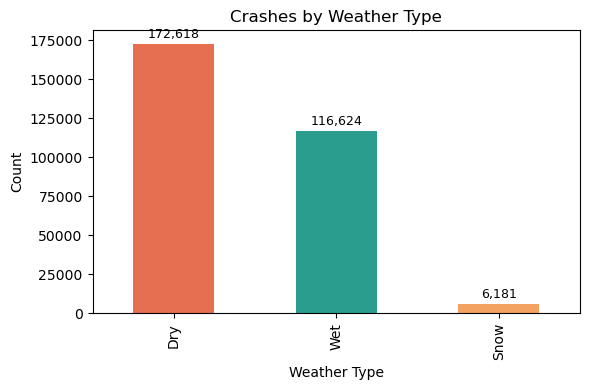

In [162]:
# Crash counts by weather_type
order = ["Dry","Wet","Snow"]
ax = (cr_w["weather_type"].value_counts()
        .reindex(order)
        .plot(kind="bar", figsize=(6,4),
              color=["#e76f51","#2a9d8f","#f4a261"]))
plt.title("Crashes by Weather Type")
plt.xlabel("Weather Type"); plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0,2),
                textcoords="offset points")
plt.tight_layout(); plt.show()



This chart shows that most crashes in D.C. happen under dry conditions (172,618 crashes), followed by wet conditions (116,624 crashes), while snowy conditions account for only 6,181 crashes. This pattern is expected since dry days are more frequent, but it also highlights that a significant share of crashes still occur during wet weather, which may indicate higher risk despite lower exposure.

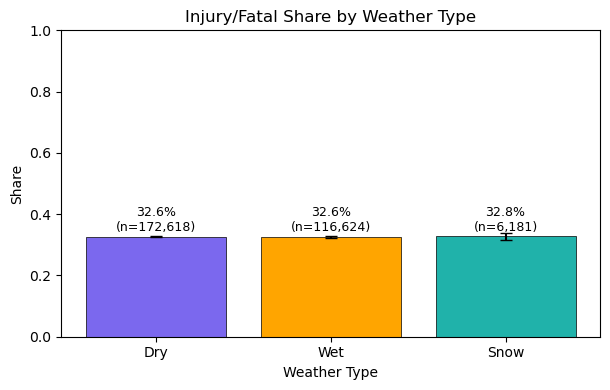

In [168]:
# data
p = shares.fillna(0).values
n = counts.fillna(0).values
k = positives.fillna(0).values
xlab = shares.index.tolist()

# Wilson interval (no extra libs)
z = 1.96
phat = k / np.where(n==0, 1, n)
den = 1 + z**2/n
center = (phat + z**2/(2*n)) / den
half = (z*np.sqrt((phat*(1-phat))/n + z**2/(4*n**2))) / den
lower, upper = center - half, center + half
yerr = np.vstack([center - lower, upper - center])

# plot
colors = ["#7B68EE", "#FFA500", "#20B2AA"]  # slate purple / orange / teal
fig, ax = plt.subplots(figsize=(6.2,4))
bars = ax.bar(xlab, phat, yerr=yerr, capsize=4, color=colors, edgecolor="black", linewidth=0.5)
ax.set_title("Injury/Fatal Share by Weather Type")
ax.set_xlabel("Weather Type"); ax.set_ylabel("Share"); ax.set_ylim(0,1)

# 1-decimal % labels + sample size
for b, val, nn in zip(bars, phat, n):
    ax.annotate(f"{val:.1%}\n(n={int(nn):,})",
                (b.get_x()+b.get_width()/2, val),
                ha="center", va="bottom", fontsize=9, xytext=(0,2),
                textcoords="offset points")
plt.tight_layout(); plt.show()

This chart shows that the injury/fatal crash share is very consistent across weather types: about 32.6% for dry and wet conditions and 32.8% for snow. This suggests that while total crash counts vary by weather, the likelihood of a crash resulting in injury or fatality is nearly the same across all weather types.

### Roadway Sensors visibility insight (weather dataset)


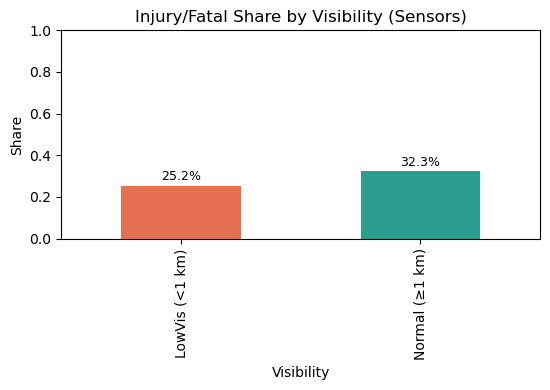

In [175]:
# Roadway Sensors: visibility vs injury/fatal 

SENS = "Roadway_Weather_Information_Systems_Sensors.csv"
wxr  = pd.read_csv(SENS, low_memory=False)

# datetime -> date
tcol = next((c for c in wxr.columns if c.lower() in {"datadatetime","timestamp","datetime"}), None)
wxr[tcol] = pd.to_datetime(wxr[tcol], errors="coerce")
wxr["date"] = wxr[tcol].dt.date

if "VISIBILITY" in wxr.columns:
    # clean visibility (e.g., "0.8 km" -> 0.8); threshold < 1 km
    vis = pd.to_numeric(wxr["VISIBILITY"].astype(str).str.extract(r'(\d+(?:\.\d+)?)')[0], errors="coerce")
    vis_day = wxr.assign(VIS=vis).groupby("date", as_index=False)["VIS"].mean()
    vis_day["vis_flag"] = np.where(vis_day["VIS"] < 1, "LowVis (<1 km)", "Normal (≥1 km)")

    # merge with crashes
    if "analysis" not in globals():
        analysis = pd.read_csv("dc_crashes_clean.csv", parse_dates=["crash_datetime"])
        analysis["date"] = analysis["crash_datetime"].dt.date
    cr_vis = analysis.merge(vis_day[["date","vis_flag"]], on="date", how="left").fillna({"vis_flag":"Normal (≥1 km)"})

    # injury/fatal share
    z = cr_vis.copy(); z["inj_or_fatal"] = z["severity"].isin(["Injury","Fatal"]).astype(int)
    s = z.groupby("vis_flag")["inj_or_fatal"].mean().reindex(["LowVis (<1 km)","Normal (≥1 km)"])

    ax = s.plot(kind="bar", figsize=(5.6,4), color=["#e76f51","#2a9d8f"])
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1%}", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=9, xytext=(0,2), textcoords="offset points")
    plt.title("Injury/Fatal Share by Visibility (Sensors)")
    plt.xlabel("Visibility"); plt.ylabel("Share"); plt.ylim(0,1); plt.tight_layout(); plt.show()
else:
    print("VISIBILITY not found in sensors; skipping.")


This chart shows that crashes with poor visibility (<1 km) are less likely to result in injury or fatality (25.2%) compared to crashes in clearer conditions (≥1 km), where the share rises to 32.3%. This suggests that reduced visibility may lower speeds, leading to fewer severe outcomes despite higher driving risks.

#### Crashes by Weather × Weekday


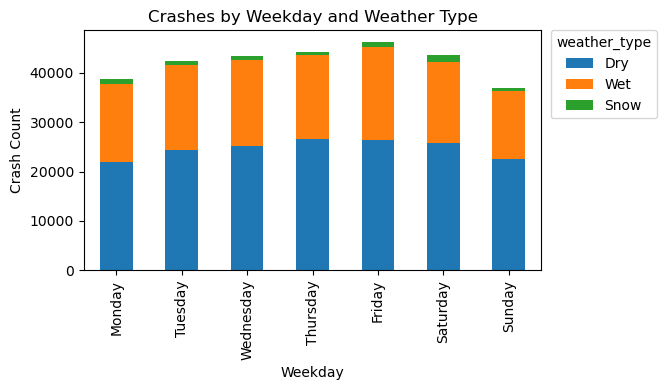

In [305]:
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
tab = pd.crosstab(cr_w["weekday"], cr_w["weather_type"]).reindex(order)[["Dry","Wet","Snow"]]

ax = tab.plot(kind="bar", figsize=(8,4), stacked=True,
              color=["#1f77b4","#ff7f0e","#2ca02c"])

plt.title("Crashes by Weekday and Weather Type")
plt.xlabel("Weekday"); plt.ylabel("Crash Count")

# park legend outside the plotting area on the right
ax.legend(title="weather_type", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

# add a bit of right margin so the legend fits cleanly
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


Crash counts peak on Thu–Fri, dip on Sunday, and the split by Dry/Wet stays pretty similar across days (snow is negligible). That suggests weekday volume-not weather-is the bigger driver of totals. We’ll control for exposure (traffic volume) in later modeling.

#### Severity Mix by Weather × Ward


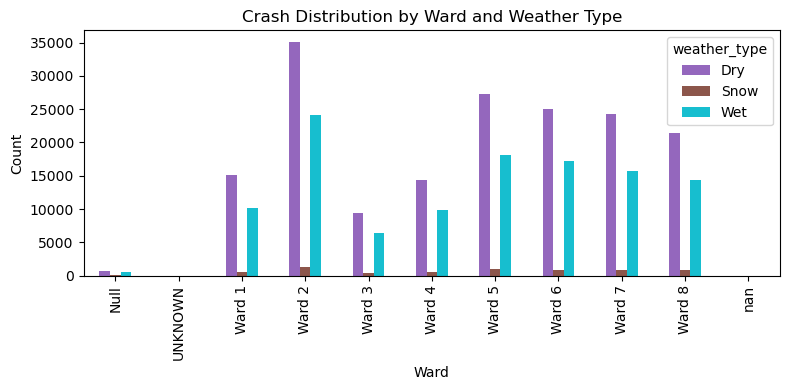

In [195]:
# identify spot, wards that are more vulnerable under wet/snow conditions

tab = pd.crosstab(cr_w["WARD"], cr_w["weather_type"])
tab.plot(kind="bar", figsize=(8,4),
         color=["#9467bd","#8c564b","#17becf"])
plt.title("Crash Distribution by Ward and Weather Type")
plt.xlabel("Ward"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

This chart shows that Ward 2 has the highest crash counts, followed by Wards 5, 6, and 7, while Ward 3 has the lowest. Across all wards, dry conditions dominate, with wet conditions also notable and snow contributing only minimally. This suggests traffic volume and urban density matter more than weather in explaining ward-level crash totals.

#### Time-of-Day × Weather (Heatmap)



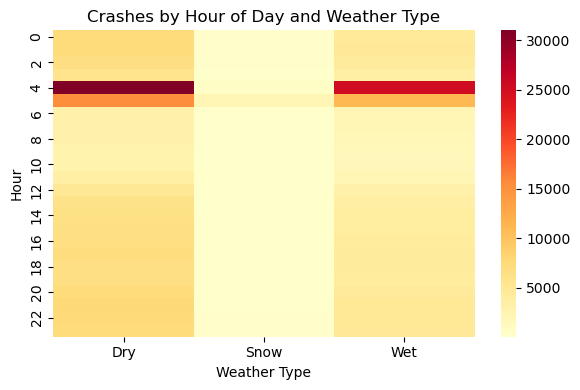

In [202]:
# clear visualization of when + under what weather conditions crashes peak.

pivot = pd.crosstab(cr_w["hour"], cr_w["weather_type"])
plt.figure(figsize=(6,4))
sns.heatmap(pivot, cmap="YlOrRd", annot=False, cbar=True)
plt.title("Crashes by Hour of Day and Weather Type")
plt.xlabel("Weather Type"); plt.ylabel("Hour")


plt.tight_layout(); plt.show()

This heatmap shows an unexpected spike in crashes around 4 AM, particularly under dry and wet conditions. Such a pattern may reflect reporting or data-recording artifacts (e.g., crashes without exact timestamps being defaulted to 4 AM), rather than a true surge in accidents at that hour. Alternatively, if valid, it could point to late-night driving risks such as fatigue, impaired driving after bars close, or reduced alertness. Outside of this anomaly, crash counts remain steady throughout the day, with snow-related crashes staying low.

In [ ]:
##--------------- Crash Severity by Weather Type (numeric table)---------------------##

In [204]:
tab = pd.crosstab(cr_w["weather_type"], cr_w["severity"], normalize="index").round(3)
print("Severity distribution within each weather type:\n")
print(tab)

Severity distribution within each weather type:

severity      Fatal  Injury  Property Damage Only
weather_type                                     
Dry           0.002   0.324                 0.674
Snow          0.000   0.327                 0.672
Wet           0.002   0.324                 0.674


In [ ]:
##---------------  Correlation between Weather & Crash Counts (per day) ---------------------##

In [245]:
if "date" not in cr_w.columns: cr_w["date"] = cr_w["crash_datetime"].dt.date
daily = cr_w.groupby("date").agg(crashes=("severity","count")).reset_index()

use = [c for c in ["tavg","tmax","tmin","precip","snow","wind","visibility"] if c in cr_w.columns]
if use:
    wxd = cr_w.groupby("date")[use].mean().reset_index()
    daily = daily.merge(wxd, on="date", how="left")
    print("Using:", use)
    print("Pearson:\n", daily[["crashes"]+use].corr(numeric_only=True).round(2))
    print("Spearman:\n", daily[["crashes"]+use].corr(method="spearman", numeric_only=True).round(2))
else:
    print("No expected weather cols found in cr_w.")


Using: ['precip', 'snow', 'visibility']
Pearson:
             crashes  precip  snow  visibility
crashes        1.00    0.01 -0.07        0.03
precip         0.01    1.00  0.12       -0.46
snow          -0.07    0.12  1.00       -0.28
visibility     0.03   -0.46 -0.28        1.00
Spearman:
             crashes  precip  snow  visibility
crashes        1.00    0.00 -0.07        0.04
precip         0.00    1.00  0.18       -0.64
snow          -0.07    0.18  1.00       -0.23
visibility     0.04   -0.64 -0.23        1.00


In [ ]:
##---------------  Statistical Test: Are Wet/Snow days riskier? ---------------------##

In [247]:
ct = pd.crosstab(cr_w["weather_type"], cr_w["severity"].isin(["Injury","Fatal"]))
chi2, p, dof, ex = chi2_contingency(ct)
print("Chi-square test p-value:", p)

Chi-square test p-value: 0.9531144492831525


In [ ]:
##---------------  show a few rows with crash + weather side-by-side --------------------- ##

In [249]:
cr_w[["crash_datetime","WARD","severity","weather_type"]].head(3)


,crash_datetime,WARD,severity,weather_type
0,2011-12-08 05:00:00,Ward 5,Property Damage Only,Wet
1,2011-12-10 21:17:00,Ward 2,Property Damage Only,Dry
2,2011-12-09 05:00:00,Ward 5,Injury,Dry


In [ ]:
##------------------ crashes per day for Dry/Wet/Snow  (uses the merged cr_w you have)---------------##

In [253]:
rate = (cr_w.groupby(["date","weather_type"]).size()
          .groupby("weather_type").mean().sort_values(ascending=False))
print("Crashes per day by weather:\n", rate.round(2))


Crashes per day by weather:
 weather_type
Dry     57.96
Wet     57.94
Snow    50.25
dtype: float64


In [ ]:
##------------------ crashes per day for Dry/Wet/Snow -------------------------##


weather_type
Dry     57.96
Wet     57.94
Snow    50.25
Name: crashes_per_day, dtype: float64


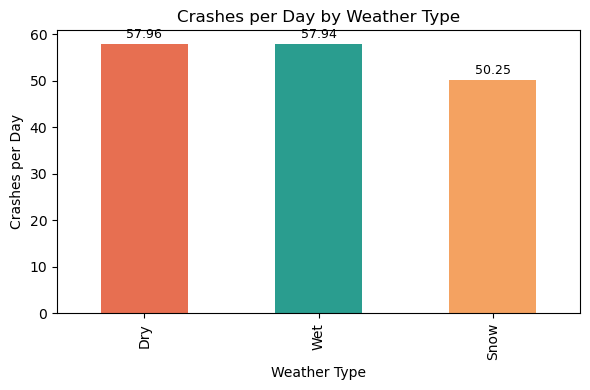

In [255]:

if "weather_type" in cr_w.columns:
    if "date" not in cr_w.columns: cr_w["date"] = cr_w["crash_datetime"].dt.date

    per_day = (cr_w.groupby(["date","weather_type"]).size()
                 .groupby("weather_type").mean()
                 .reindex(["Dry","Wet","Snow"]).dropna())

    print(per_day.round(2).rename("crashes_per_day"))

    ax = per_day.plot(kind="bar", figsize=(6,4), color=["#e76f51","#2a9d8f","#f4a261"])
    plt.title("Crashes per Day by Weather Type")
    plt.xlabel("Weather Type"); plt.ylabel("Crashes per Day")

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=9, xytext=(0,2),
                    textcoords="offset points")

    plt.tight_layout(); plt.show()
else:
    print("weather_type not in cr_w; skip.")


This chart shows that crashes occur at nearly the same daily rate in dry (57.96/day) and wet (57.94/day) conditions, while snow conditions have slightly fewer crashes per day (50.25/day). This suggests that weather type does not drastically change the overall daily crash frequency, though snow days see a modest reduction, likely because fewer drivers are on the road.

## 5. Data Preparation (for Modeling)

To prepare for midterm predictive modeling, we construct a modeling-ready dataset:  
- Target = crash severity (multiclass) or injury/fatal (binary).  
- Encode categorical variables (ward, weekday, weather_type).  
- Scale numeric features (vehicles, pedestrians).  
- Split into train/test sets.  
This ensures the dataset is clean and structured for applying machine learning in the next phase.

In [177]:
prep = cr_w.copy()
prep["is_injury_or_fatal"] = prep["severity"].isin(["Injury","Fatal"]).astype(int)

# one-hot encode categoricals
cats = [c for c in ["WARD","weekday","weather_type"] if c in prep.columns]
prep_enc = pd.get_dummies(prep, columns=cats, drop_first=True)

# fill numeric counts
for c in ["TOTAL_VEHICLES","TOTAL_BICYCLES","TOTAL_PEDESTRIANS"]:
    if c in prep_enc.columns: prep_enc[c] = prep_enc[c].fillna(0)

# scale counts
cnt = [c for c in ["TOTAL_VEHICLES","TOTAL_BICYCLES","TOTAL_PEDESTRIANS"] if c in prep_enc.columns]
if cnt:
    sc = StandardScaler()
    prep_enc[cnt] = sc.fit_transform(prep_enc[cnt])

# define target and split
y = prep_enc["severity"]
X = prep_enc.drop(columns=["severity","crash_datetime","date","ADDRESS"], errors="ignore")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (230554, 31) (76852, 31)


In [140]:
# save for teammates / slides
prep_enc.to_csv("dc_crashes_prepared_with_weather.csv", index=False)
print("Saved prepared dataset → dc_crashes_prepared_with_weather.csv")


Saved prepared dataset → dc_crashes_prepared_with_weather.csv


In [257]:
# ===== 5a) Small feature engineering  =====
# add hour/weekend/rush_hour 
prep = cr_w.copy()
prep["is_injury_or_fatal"] = prep["severity"].isin(["Injury","Fatal"]).astype(int)
prep["hour"] = prep["crash_datetime"].dt.hour
prep["weekend"] = prep["weekday"].isin(["Saturday","Sunday"]).astype(int)
prep["rush_hour"] = (prep["hour"].between(7,9) | prep["hour"].between(16,19)).astype(int)


In [259]:
# ===== 5b) Class balance (multiclass + binary) =====
print("Severity distribution (%):")
print(prep["severity"].value_counts(normalize=True).mul(100).round(1))
print("\nInjury/Fatal (binary) rate:", f"{prep['is_injury_or_fatal'].mean():.1%}")


Severity distribution (%):
severity
Property Damage Only    67.7
Injury                  32.1
Fatal                    0.2
Name: proportion, dtype: float64

Injury/Fatal (binary) rate: 32.3%


As we can see here, the majority of crashes (67.7%) in DC result in property damage only, while about one-third (32.1%) involve injuries. Fatal crashes are extremely rare at 0.2%. Overall, the combined injury/fatal rate of 32.3% highlights that nearly 1 in 3 crashes have serious consequences.

In [312]:
# ===== 5c) Build BOTH unscaled and scaled matrices (trees vs linear models) =====
from sklearn.preprocessing import StandardScaler

cats = [c for c in ["WARD","weekday","weather_type"] if c in prep.columns]
counts = [c for c in ["TOTAL_VEHICLES","TOTAL_BICYCLES","TOTAL_PEDESTRIANS"] if c in prep.columns]

# unscaled (good for trees)
prep_unscaled = pd.get_dummies(prep, columns=cats, drop_first=True)
for c in counts: prep_unscaled[c] = prep_unscaled[c].fillna(0)

# scaled copy (good for linear/NN)
prep_scaled = prep_unscaled.copy()
if counts:
    sc = StandardScaler()
    prep_scaled[counts] = sc.fit_transform(prep_scaled[counts])


In [263]:
# ===== 5d) Leakage guard + split =====
leak = ["crash_datetime","date","ADDRESS","X","Y"]  # columns we don't want the model to "peek" at
def make_Xy(df):
    y = df["severity"]
    X = df.drop(columns=["severity"] + leak, errors="ignore")
    return X, y

X_u, y_u = make_Xy(prep_unscaled)
X_s, y_s = make_Xy(prep_scaled)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_s, y_s, test_size=0.25, random_state=42, stratify=y_s
)
print("Train/Test shapes (scaled):", X_train.shape, X_test.shape)


Train/Test shapes (scaled): (230554, 33) (76852, 33)


In [265]:
# ===== 5e) Numeric "importance" preview (not a model) =====
corr = prep_scaled.corr(numeric_only=True)["is_injury_or_fatal"].sort_values(ascending=False)
print("\nTop correlations with Injury/Fatal (preview):")
print(corr.head(12).round(3))


Top correlations with Injury/Fatal (preview):
is_injury_or_fatal    1.000
TOTAL_PEDESTRIANS     0.236
TOTAL_BICYCLES        0.138
LONGITUDE             0.049
WARD_Ward 7           0.035
WARD_Ward 5           0.016
WARD_Ward 4           0.015
WARD_Ward 8           0.014
month                 0.007
weekday_Sunday        0.006
weekend               0.005
weather_type_Wet      0.005
Name: is_injury_or_fatal, dtype: float64


In [267]:
# ===== 5f) Save both versions for teammates/models =====
prep_unscaled.to_csv("dc_crashes_prepared_unscaled.csv", index=False)
prep_scaled.to_csv("dc_crashes_prepared_scaled.csv", index=False)
print("Saved: dc_crashes_prepared_unscaled.csv  |  dc_crashes_prepared_scaled.csv")


Saved: dc_crashes_prepared_unscaled.csv  |  dc_crashes_prepared_scaled.csv


In [269]:
# ===== 5g) Class weights for medeling purpose ======
from sklearn.utils.class_weight import compute_class_weight
classes = y_s.unique()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_s)
print("Class weights (use later):", dict(zip(classes, weights)))


Class weights (use later): {'Property Damage Only': 0.4923419419419419, 'Injury': 1.0382251222609495, 'Fatal': 175.16011396011396}


In [271]:
print("Features (unscaled, scaled):", X_u.shape[1], X_s.shape[1])


Features (unscaled, scaled): 33 33


In [275]:
from scipy.stats import chi2_contingency
p = chi2_contingency(pd.crosstab(cr_w["weather_type"], cr_w["severity"].isin(["Injury","Fatal"])))[1]
print("Severity vs weather_type (chi-square) p-value:", p)


Severity vs weather_type (chi-square) p-value: 0.9531144492831525


In [ ]:
# Most crashes occur on Dry days, but this reflects exposure (more people driving).

# Severity shares (Injury/Fatal vs. Property Damage) are nearly identical across Dry, Wet, and Snow.

# Chi-square test confirms no significant difference (p ≈ 0.95).

# By contrast, low-visibility conditions (from roadway sensors) show a noticeably higher injury/fatal share → weather exposure matters more than weather type.

In [278]:
# Missingness snapshot (top 10) + duplicates check
analysis.isna().mean().sort_values(ascending=False).head(10).round(3)


ADDRESS           0.0
crash_datetime    0.0
year              0.0
month             0.0
hour              0.0
weekday           0.0
severity          0.0
LATITUDE          0.0
LONGITUDE         0.0
WARD              0.0
dtype: float64

In [280]:
# Duplicates by date/ward/address/severity (or your crash_id if you have it)
analysis.duplicated(subset=["crash_datetime","WARD","ADDRESS","severity"]).sum()


342

In [282]:
# Severity distribution within each weather type (table)
pd.crosstab(cr_w["weather_type"], cr_w["severity"], normalize="index").round(3)


severity,Fatal,Injury,Property Damage Only
weather_type,,,
Dry,0.002,0.324,0.674
Snow,0.000,0.327,0.672
Wet,0.002,0.324,0.674


In [284]:
# Weekday x Weather shares (row-normalized), compact table
pd.crosstab(cr_w["weekday"], cr_w["weather_type"], normalize="index").round(3)


weather_type,Dry,Snow,Wet
weekday,,,
Friday,0.571,0.022,0.407
Monday,0.565,0.026,0.408
Saturday,0.590,0.030,0.380
Sunday,0.614,0.013,0.373
Thursday,0.602,0.013,0.385
Tuesday,0.572,0.023,0.406
Wednesday,0.578,0.020,0.402


Across all weekdays, most crashes occur under dry conditions, followed by wet conditions, with snow contributing very little. Sundays and Thursdays show the highest share of crashes in dry weather, while Mondays and Fridays have a relatively higher share in wet weather.

In [286]:
# Feature inventory (helps slides)
print("Features (unscaled, scaled):", X_u.shape[1], X_s.shape[1])


Features (unscaled, scaled): 33 33


In [288]:
# Top numeric correlations with the binary target (preview of what matters)
prep_scaled.corr(numeric_only=True)["is_injury_or_fatal"].sort_values(ascending=False).head(10).round(3)


is_injury_or_fatal    1.000
TOTAL_PEDESTRIANS     0.236
TOTAL_BICYCLES        0.138
LONGITUDE             0.049
WARD_Ward 7           0.035
WARD_Ward 5           0.016
WARD_Ward 4           0.015
WARD_Ward 8           0.014
month                 0.007
weekday_Sunday        0.006
Name: is_injury_or_fatal, dtype: float64

Pedestrian and bicycle involvement have the strongest positive correlations with injury or fatal outcomes, meaning crashes with pedestrians or cyclists are more likely to be severe. Location factors (longitude and wards) also show some influence, though weaker. Weather type and time-based features (month, weekend, weekday) have minimal correlation, suggesting their effect may only appear when combined with other variables in a predictive model.